In [2]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

# Datasets

## IM-Fusion

In [3]:
# Read RNA CTGs.
rna_ctgs = (pd.read_csv('../data/processed/sanger/star/ctgs.txt', sep='\t')
              .sort_values(['p_value']))

# Read RNA insertions.
insertions_rna = (pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
                    .query('support >= 10'))

## Sanger DNA-seq

In [4]:
# Read DNA CTGs.
dna_hits = (pd.read_excel('../data/external/sanger/publication/'
                          'WTSI_DJA_TAPJ_TA_PAX_ONC_B220PLUS_CD19PLUS_CIS_MERGER.xlsx')
              .rename(columns={
                 'Gene': 'gene_name',
                 'Number of Tumours in CIS': 'n_samples'
              })
              .get(['gene_name', 'n_samples'])
              .drop_duplicates())

dna_hits.head()

,gene_name,n_samples
0,CIS7:37319336_15k,14
1,Ophn1,11
2,Jak1,10
3,CIS7:143203112_120k,9
4,Kit,8


In [5]:
from imfusion.model import Insertion
from nbsupport import util, insertions as nb_ins


def _insertions_from_sanger_bed(bed_data):
    """Converts Sanger bed format into an insertion DataFrame."""
    
    name_info = bed_data['name'].str.extract(
        r'_(?P<sample>TAP[\w-]+)\.', expand=True)
    
    col_order = ['id', 'seqname', 'position', 'strand',
                 'support_junction', 'support_spanning',
                 'support', 'sample']
    
    return pd.DataFrame({
        'id': ['INS_{}'.format(i + 1) 
               for i in range(len(bed_data))],
        'seqname': bed_data['chrom'].str.replace('chr', ''),
        'position': bed_data['chromStart'],
        'strand': bed_data['strand'].map({'-': -1, '+': 1}),
        'support_junction': bed_data['score'],
        'support_spanning': 0,
        'support': bed_data['score'],
        'sample': name_info['sample']
    }, columns=col_order)


# Read insertions from Sanger bed file.
bed_path = ('../data/external/sanger/publication/TAPJ/JANUARY_2015_FILE_TRANFSER/'
            'WTSI_DJA_TAPJ_20130328_TA_PAX_ONC_B220+_CD19+_INSERTIONS_DEFIRESTORMED.bed')

insertions_dna = (util.read_bed(bed_path)
                      .pipe(_insertions_from_sanger_bed))

# Annotate insertions with mm9 genes. Here we assign insertions to genes 
# within 20kb window and then restrict annotation to closest gene.
genes_mm9 = util.fetch_biomart_genes_mm9()

insertion_objs = Insertion.from_frame(insertions_dna)
annotated_objs = nb_ins.annotate_insertions(
    insertion_objs, window=20000, genes=genes_mm9, select_closest=True)

insertions_dna = Insertion.to_frame(annotated_objs)
insertions_dna.head()

,id,seqname,position,strand,support_junction,support_spanning,support,gene_distance,gene_id,gene_name,sample
0,INS_1,7,76004135,-1,9,0,9,NaN,NaN,NaN,TAPJ49-1a
1,INS_2,7,116931954,1,6,0,6,6415.0,ENSMUSG00000034825,Nrip3,TAPJ49-1a
2,INS_3,7,130823505,1,4,0,4,NaN,NaN,NaN,TAPJ49-1a
3,INS_4,14,15533200,-1,3,0,3,2339.0,ENSMUSG00000021733,Slc4a7,TAPJ49-1a
4,INS_5,14,17511791,1,1,0,1,0.0,ENSMUSG00000017491,Rarb,TAPJ49-1a


In [6]:
# Quick sanity check, to see if the expected hits are among the top genes.
(insertions_dna.groupby(['gene_id', 'gene_name'])
               ['sample'].nunique()
               .sort_values(ascending=False)
               .head(n=10))

gene_id             gene_name
ENSMUSG00000092329  Gm20388      12
ENSMUSG00000056899  Immp2l       11
ENSMUSG00000030849  Fgfr2        11
ENSMUSG00000028530  Jak1         10
ENSMUSG00000021699  Pde4d         9
ENSMUSG00000068205  Macrod2       9
ENSMUSG00000020919  Stat5b        8
ENSMUSG00000030067  Foxp1         8
ENSMUSG00000022708  Zbtb20        8
ENSMUSG00000041654  Slc39a11      7
Name: sample, dtype: int64

# Rank comparison

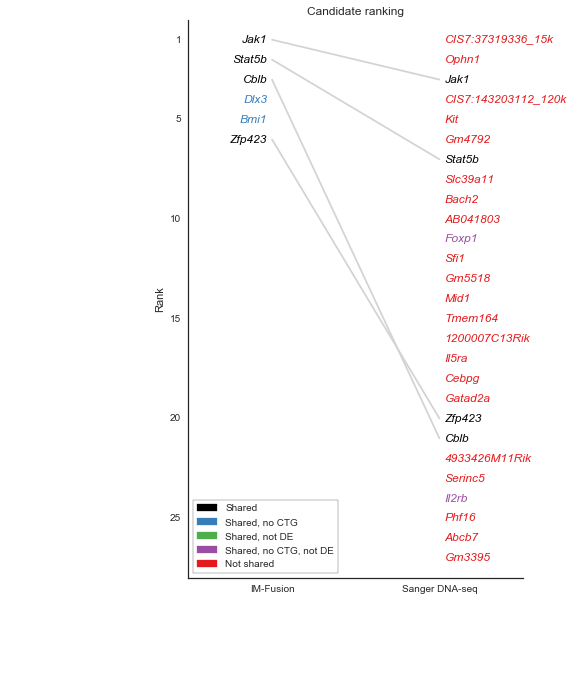

In [7]:
import toolz

from nbsupport import rank
from imfusion.expression import read_exon_counts

# TODO: compare shared with filtered or unfiltered insertions? 
# TODO: DE based on IM-Fusion insertions or on Sanger analysis?

# Read counts and create gene_id --> gene_name map needed for annotate_de.
exon_counts = read_exon_counts('../data/processed/sanger/star/expression.txt')

gene_id_map = toolz.merge(
     dict(zip(insertions_dna['gene_name'], insertions_dna['gene_id'])),
     dict(zip(insertions_rna['gene_name'], insertions_rna['gene_id'])))

# Compare and annotate rankings.
ranks = (
    rank.compare_ranks(rna_ctgs.query('de_pvalue <= 0.05'), dna_hits,
                       suffixes=('_rna', '_dna'))
        .pipe(rank.annotate_ctg, ctgs=rna_ctgs, col_name='ctg_rna')
        .pipe(rank.annotate_ctg, ctgs=dna_hits, col_name='ctg_dna')
        .pipe(rank.annotate_ins, insertions=insertions_rna, col_name='ins_rna')
        .pipe(rank.annotate_ins, insertions=insertions_dna, col_name='ins_dna')
        .pipe(rank.annotate_de, insertions=insertions_rna, 
              exon_counts=exon_counts, gene_id_map=gene_id_map,
              col_name='is_de')
        .pipe(rank.annotate_type))
    
# Plot ranking.
order = rank.RANK_TYPES
palette = (['black'] + sns.color_palette('Set1')[1:4] + 
           [sns.color_palette('Set1')[0]])

fig, ax = plt.subplots(figsize=(6, 10)) 
rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                label='gene_name', hue='type', ax=ax,
                palette=palette, order=order,
                legend_kws={'frameon': True, 
                            'loc': 'lower left'},
                label_kws={'fontstyle': 'italic'}) 
ax.set_xticklabels(['IM-Fusion', 'Sanger DNA-seq'])
ax.set_title('Candidate ranking');

In [8]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.2, 4.2)) 
    rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                    label='gene_name', hue='type', ax=ax,
                    palette=palette, order=order,
                    legend_kws={'frameon': True, 
                                'loc': 'lower left'},
                    label_kws={'fontstyle': 'italic'}) 
    ax.set_xticklabels(['IM-Fusion\n(paired-end)', 'DNA-seq\n(Publication)'])
    ax.set_title('Candidate ranking')
    
    fig.savefig('../reports/figures/fig_5a_ctg_ranks.pdf', bbox_inches='tight')
    plt.close(fig)

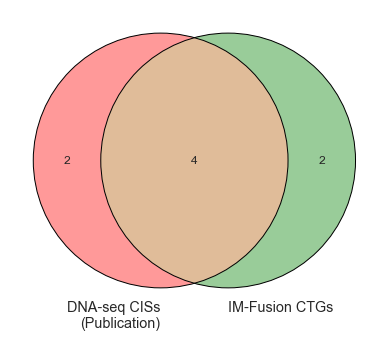

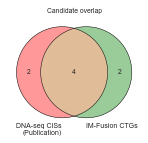

In [9]:
from matplotlib_venn import venn2, venn2_circles

rna_genes = set(rna_ctgs.query('de_pvalue < 0.05')['gene_name'])
dna_genes = {'Jak1', 'Stat5b', 'Cblb', 'Zfp423', 'Foxp1', 'Il2rb'}

fig, ax = plt.subplots()
venn2((rna_genes, dna_genes), 
      set_labels=['DNA-seq CISs\n(Publication)',
                  'IM-Fusion CTGs'],
      ax=ax)
venn2_circles((rna_genes, dna_genes), ax=ax, lw=1);


with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.4, 2.4))
    venn = venn2(
        (rna_genes, dna_genes), 
        set_labels=['DNA-seq CISs\n(Publication)',
                    'IM-Fusion CTGs'],
        ax=ax)
    venn2_circles((rna_genes, dna_genes), ax=ax, lw=0.5);
    
    for label in venn.set_labels:
        label.set_fontsize(7)
        
    ax.set_title('Candidate overlap')
        
    fig.savefig('../reports/figures/fig_5b_ctg_overlap.pdf', bbox_inches='tight')

# Single vs paired-end

In [10]:
rna_ctgs_single = pd.read_csv('../data/processed/sanger/star-single/ctgs.txt', sep='\t')
rna_ctgs_single

,gene_id,gene_name,p_value,q_value,n_samples,de_pvalue,de_direction,de_test
0,ENSMUSG00000028530,Jak1,2.550840e-19,1.428470e-17,7,0.000328,1,exon
1,ENSMUSG00000020919,Stat5b,1.408681e-14,7.888615e-13,5,0.000620,1,exon
2,ENSMUSG00000022637,Cblb,2.116503e-12,1.185242e-10,5,0.000620,-1,exon
3,ENSMUSG00000001510,Dlx3,1.086529e-06,6.084565e-05,2,0.010375,1,exon
4,ENSMUSG00000004043,Stat5a,3.006863e-06,1.683843e-04,2,0.092938,-1,exon
5,ENSMUSG00000026739,Bmi1,3.242743e-06,1.815936e-04,2,0.013734,1,exon
6,ENSMUSG00000024241,Sos1,2.171508e-05,1.216044e-03,2,0.285375,-1,exon
7,ENSMUSG00000045333,Zfp423,8.086889e-05,4.528658e-03,2,0.013734,1,exon
8,ENSMUSG00000030068,Gm20696,2.077424e-04,1.163357e-02,2,0.500000,-1,exon
9,ENSMUSG00000030067,Foxp1,4.317958e-04,2.418056e-02,2,0.206415,1,exon


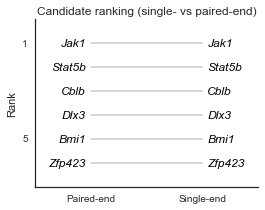

In [11]:
ranks_single = rank.compare_ranks( 
    rna_ctgs.query('de_pvalue < 0.05'),
    rna_ctgs_single.query('de_pvalue < 0.05'),
    suffixes=('_paired', '_single'))

fig, ax = plt.subplots(figsize=(4, 3))
rank.plot_ranks(ranks_single, rank_a='rank_paired', ax=ax,
                rank_b='rank_single', label='gene_name',
                label_kws={'fontstyle': 'italic'})
ax.set_xticklabels(['Paired-end', 'Single-end'])
ax.set_title('Candidate ranking (single- vs paired-end)')

In [12]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.2, 1.2)) 
    rank.plot_ranks(ranks_single, rank_a='rank_paired', ax=ax,
                    rank_b='rank_single', label='gene_name',
                    label_kws={'fontstyle': 'italic'})
    ax.set_xticklabels(['Paired-end', 'Single-end'])
    ax.set_title('Candidate ranking (single- vs paired-end)')
    fig.savefig('../reports/figures/fig_5c_single.pdf', bbox_inches='tight')
    plt.close(fig)

In [13]:
# Check number of samples per gene.
pd.merge(rna_ctgs[['gene_name', 'n_samples']],
         rna_ctgs_single[['gene_name', 'n_samples']],
         on='gene_name', suffixes=['_paired', '_single'])

,gene_name,n_samples_paired,n_samples_single
0,Jak1,9,7
1,Stat5b,7,5
2,Cblb,5,5
3,Dlx3,2,2
4,Stat5a,2,2
5,Bmi1,2,2
6,Sos1,2,2
7,Zfp423,2,2
8,Gm20696,2,2


In [14]:
insertions_paired = pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
insertions_single = pd.read_csv('../data/processed/sanger/star-single/insertions.txt', sep='\t')

(pd.merge(insertions_paired.query('support >= 10')
                           .groupby(['sample', 'gene_name'])['support'].max()
                           .to_frame('support_paired').reset_index(),
          insertions_single.query('support >= 10')
                           .groupby(['sample', 'gene_name'])['support'].max()
                           .to_frame('support_single').reset_index(), 
          on=['sample', 'gene_name'], how='outer')
   .query('gene_name == {!r}'.format(list(ranks_single['gene_name'])))
   .sort_values(['gene_name', 'support_paired'], ascending=[True, False]))

,sample,gene_name,support_paired,support_single
61,TAPJ49_5c,Bmi1,1714.0,443.0
124,TAPJ64_3d,Bmi1,549.0,226.0
100,TAPJ53_3m,Cblb,1286.0,761.0
162,TAPJ84_3c,Cblb,670.0,374.0
63,TAPJ49_5c,Cblb,651.0,334.0
83,TAPJ52_2a,Cblb,569.0,272.0
0,TAPJ102_5c,Cblb,498.0,232.0
101,TAPJ53_3m,Dlx3,47.0,25.0
2,TAPJ102_5c,Dlx3,26.0,22.0
163,TAPJ84_3c,Jak1,1947.0,177.0


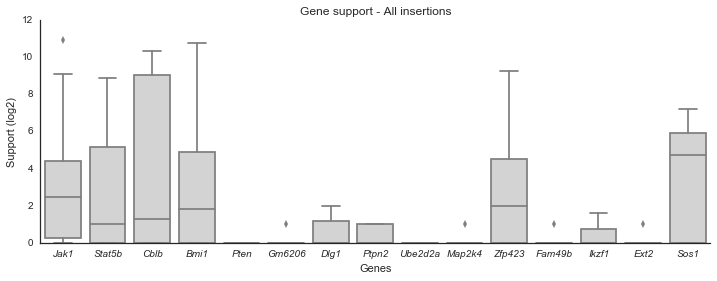

In [21]:
# Rank genes using all insertions.
insertions_rna_all = (
    pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
      .query('seqname != "1"')
      .assign(support_log=lambda df: np.log2(df['support'])))

ranked_genes = (insertions_rna_all
                .groupby('gene_name')
                ['sample'].nunique()
                .sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=insertions_rna_all, x='gene_name', y='support_log',
            order=ranked_genes.head(n=15).index, color='lightgrey', ax=ax)
sns.despine()
ax.set_xlabel('Genes')
ax.set_ylabel('Support (log2)')
ax.set_title('Gene support - All insertions')
plt.setp(ax.get_xticklabels(), fontstyle='italic');

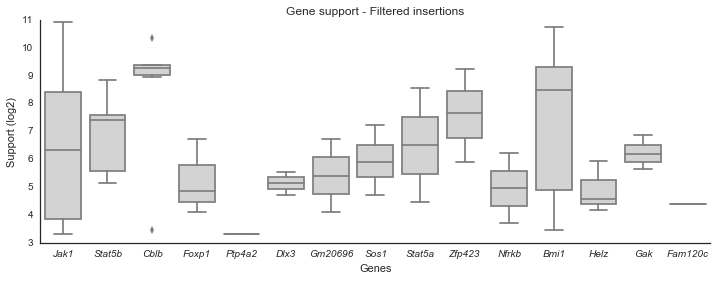

In [23]:
# Rank genes using insertions with support >= 10.
insertions_rna_all_filt = insertions_rna_all.query('support >= 10')

ranked_genes_filt = (insertions_rna_all_filt
                     .groupby('gene_name')
                     ['sample'].nunique()
                     .sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=insertions_rna_all_filt, x='gene_name', y='support_log',
            order=ranked_genes_filt.head(n=15).index, color='lightgrey', ax=ax)
sns.despine()
ax.set_xlabel('Genes')
ax.set_ylabel('Support (log2)')
ax.set_title('Gene support - Filtered insertions')
plt.setp(ax.get_xticklabels(), fontstyle='italic');

In [24]:
with sns.plotting_context('paper', font_scale=0.7):    
    fig, axes = plt.subplots(figsize=(5.5, 5), nrows=2)
    
    sns.boxplot(data=insertions_rna_all, x='gene_name', y='support_log',
                order=ranked_genes.head(n=15).index, color='lightgrey', ax=axes[0])
    plt.setp(axes[0].get_xticklabels(), fontstyle='italic')
    
    sns.boxplot(data=insertions_rna_all_filt, x='gene_name', y='support_log',
                order=ranked_genes_filt.head(n=15).index, color='lightgrey', ax=axes[1])
    plt.setp(axes[1].get_xticklabels(), fontstyle='italic')
    
    for ax in axes:
        ax.set_xlabel('Genes')
        ax.set_ylabel('Support (log2)')

    axes[0].set_title('All insertions')
    axes[1].set_title('Filtered insertions (support >= 10)')
    
    sns.despine()
    plt.tight_layout()
    
    fig.savefig('../reports/supplemental/figures/fig_s3_ball_support.pdf', bbox_inches='tight')
    plt.close(fig)

In [18]:
from io import StringIO

def _summarize(ins_dna, ins_rna, gene):
    ins_dna = ins_dna.query('gene_name == {!r}'.format(gene))
    ins_rna = ins_rna.query('gene_name == {!r}'.format(gene))
    
    rna_samples = set(ins_rna['sample'].str.replace('_', '-'))
    
    summ = (ins_dna.assign(in_rna=lambda df: df['sample'].isin(rna_samples))
                   .get(['sample', 'seqname', 'position', 'support', 'in_rna'])
                   .sort_values('support', ascending=False)
                   .rename(columns={
                       'seqname': 'chrom',
                       'in_rna': 'rnaseq'
                   }))
    
    return summ
    
    
for gene in ['Jak1', 'Stat5b', 'Foxp1', 'Zfp423', 'Cblb', 'Il2rb']:
    buf = StringIO()
    _summarize(insertions_dna, insertions_rna, gene=gene).to_latex(buf, index=False)
    
    print(gene)
    print(buf.getvalue())

Jak1
\begin{tabular}{llrrl}
\toprule
     sample & chrom &   position &  support & rnaseq \\
\midrule
  TAPJ84-3c &     4 &  100864603 &      669 &   True \\
  TAPJ49-1a &     4 &  100921507 &      666 &   True \\
  TAPJ52-2c &     4 &  100892389 &      336 &   True \\
  TAPJ52-2a &     4 &  100888660 &      312 &   True \\
  TAPJ87-6j &     4 &  100920339 &       92 &   True \\
  TAPJ72-3c &     4 &  100864603 &       38 &   True \\
  TAPJ64-1g &     4 &  100908538 &       18 &   True \\
  TAPJ49-5c &     4 &  100886398 &        4 &   True \\
   TAPJ7-2e &     4 &  100925452 &        2 &   True \\
 TAPJ102-5c &     4 &  100899386 &        1 &  False \\
\bottomrule
\end{tabular}

Stat5b
\begin{tabular}{llrrl}
\toprule
     sample & chrom &   position &  support & rnaseq \\
\midrule
  TAPJ72-3c &    11 &  100689140 &      122 &   True \\
  TAPJ68-5a &    11 &  100683416 &       61 &   True \\
  TAPJ64-1g &    11 &  100671851 &       61 &   True \\
  TAPJ49-5c &    11 &  100687148 &     

In [19]:
insertions_rna.query('gene_name == "Zfp423"')

,id,seqname,position,strand,support_junction,support_spanning,support,feature_name,feature_strand,feature_type,ffpm,ffpm_junction,ffpm_spanning,gene_id,gene_name,gene_strand,novel_transcript,orientation,sample,transposon_anchor
1562,TAPJ49_1a.INS_848,8,87904549,-1,200,1,201,SD,1,SD,2.733127,2.719529,0.013598,ENSMUSG00000045333,Zfp423,-1.0,NaN,sense,TAPJ49_1a,1043
6029,TAPJ84_3c.INS_260,8,87904549,-1,600,0,600,SD,1,SD,6.560066,6.560066,0.000000,ENSMUSG00000045333,Zfp423,-1.0,NaN,sense,TAPJ84_3c,1043
6033,TAPJ84_3c.INS_262,8,87943548,-1,59,0,59,SD,1,SD,0.645073,0.645073,0.000000,ENSMUSG00000045333,Zfp423,-1.0,STRG.22131.2,sense,TAPJ84_3c,1043
